# Cluster together addresses that are similar in terms of their Energy Class and Solar Potential

In [1]:
from utils import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Hard coded values

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
combined_data_subdir = 'out_clean'                #subdir in which we have the combined info
energy_cls_filename = 'energy_classes_clean.csv'  #filename with the energy label classification info
combined_filename = 'consolidated_enclass_solar.csv' #filename in which we have the combined info

#### Read the data

In [5]:
energy_cls_f = os.path.join(data_dir, energy_cls_filename)
combined_f = os.path.join(data_dir, combined_data_subdir, combined_filename)
en = pd.read_csv(energy_cls_f, sep=';')
ensol = pd.read_csv(combined_f, sep=';').drop(columns=['Unnamed: 0'])
cols = ['geometry', 'EnergyLabelClassification', 'StreetName', 'HouseNumber', 'ZipCode',\
        'CityName', 'HeatSupply', 'LatestYearOfConstruction']
gr = ensol.drop(columns=['byg_id']).groupby(by=cols).agg('mean')
gr.reset_index(inplace=True)

We need to distil the information such that we maintain what could be most useful in terms of clustering. 

Thus we can safely combine into a single column the pieces of information making up the address and the latest year in which the building was renovated (or construction year if it's a new building).

#### Create new columns for the Energy Label Classification and HeatSupply

In [6]:
# Combine the address forming columns and the year column in a single one.
# This will serve as our unique identifier.

def create_address(x):
    result = '{}_{}_{}_{}_{}'.format(x['StreetName'], x['HouseNumber'],\
                                     x['ZipCode'], x['CityName'], x['LatestYearOfConstruction'])
    return result
gr['address_year'] = gr.apply(lambda x: create_address(x), axis=1)

#Keep only the columns that we need for clustering
cols = ['address_year', 'EnergyLabelClassification', 'HeatSupply', 'solgruppe1', 'solgruppe2', 'solgruppe3']
df = gr[cols]

for col in cols[1:3]:
    df[col] = df[col].astype('category')

/home/osboxes/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Pre-process the categorical columns

'EnergyLabelClassification' and 'HeatSupply' are categorical and cannot be readily used by KMeans. <br>
We need create some numerical features based on them. <br>
Keep it simple: use Pandas' get_dummies which will create one additional column for each distinct value in the original column.

In [7]:
df1 = pd.get_dummies(df.drop(columns=['address_year', 'solgruppe1', 'solgruppe2', 'solgruppe3'])) 
df2 = pd.concat([df[['solgruppe1', 'solgruppe2', 'solgruppe3']], df1], axis=1)

Now that we have the data in the right format we need to create the clusters.<br>
Question: how we know how many to create?<br>
One possible approach is to use the Elbow method to track where *inertia* or *within-cluster sum-of-squares* begins to flatten as the number of clusters grows. The idea is that points which are OK clustered together should be close to the cluster's centroid and will thus have a small inertia and that above a number of clusters the decrease of the inertia should begin to flatten.
As with anything, there are drawbacks with this approach, but then again time is ticking.<br>

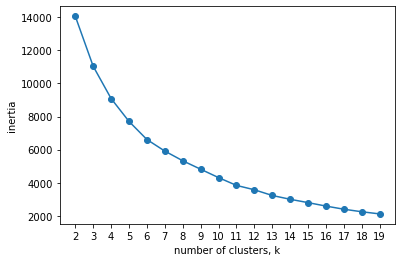

In [8]:
X = df2
ks = range(2, 20)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Looking at the graph, 10 would look like a reasonable choice to settle on. 

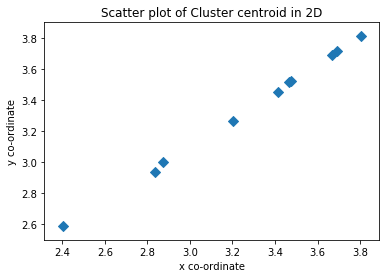

Text(0.5, 1.0, 'Barchart showing number of points assigned to each cluster')

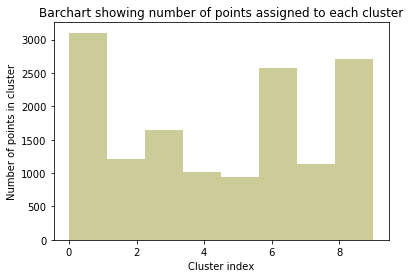

In [21]:
model = KMeans(n_clusters=10,random_state=42)
model.fit(X)
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
labels = model.labels_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.title('Scatter plot of Cluster centroid in 2D')
plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.show()
sns.distplot(labels, kde=False, rug=False,bins=8,color='olive');
plt.xlabel('Cluster index')
plt.ylabel('Number of points in cluster')
plt.title('Barchart showing number of points assigned to each cluster')

#### Add the cluster labels to the dataframe and check the features inside points of the same cluster

In [22]:
labels_df = pd.DataFrame(labels, columns=['cluster'])

df3 = pd.concat([df2, labels_df], axis=1)
df3.head()

,solgruppe1,solgruppe2,solgruppe3,EnergyLabelClassification_A,EnergyLabelClassification_B,EnergyLabelClassification_C,EnergyLabelClassification_D,EnergyLabelClassification_E,EnergyLabelClassification_F,EnergyLabelClassification_G,HeatSupply_Bygas,HeatSupply_Elektricitet,HeatSupply_Fjernvarme,HeatSupply_Naturgas,HeatSupply_Olie,HeatSupply_Petroleum,HeatSupply_Træ,HeatSupply_Træflis,HeatSupply_Træpiller,cluster
0,3.2,3.2,3.6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9
1,4.0,4.0,4.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9
2,1.8,2.0,3.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7
3,2.6,2.6,3.2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7
4,4.0,4.0,4.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3


#### Melt back the EnergyLabelClassification and HeatSupply columns 

In [23]:
cols_to_melt = ['EnergyLabelClassification', 'HeatSupply']

df4 = df3.copy()

def melt_colum(x, col_prefix):
    cols = [col for col in x.index.tolist() if col.startswith(col_prefix)]
    result = [col.split('_')[1] for col in cols if x[col]==1]
    return result[0]

for col in cols_to_melt:
    df4[col] = df4.apply(lambda x: melt_colum(x, col, ), axis=1)
    
df4.head()

,solgruppe1,solgruppe2,solgruppe3,EnergyLabelClassification_A,EnergyLabelClassification_B,EnergyLabelClassification_C,EnergyLabelClassification_D,EnergyLabelClassification_E,EnergyLabelClassification_F,EnergyLabelClassification_G,...,HeatSupply_Fjernvarme,HeatSupply_Naturgas,HeatSupply_Olie,HeatSupply_Petroleum,HeatSupply_Træ,HeatSupply_Træflis,HeatSupply_Træpiller,cluster,EnergyLabelClassification,HeatSupply
0,3.2,3.2,3.6,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,9,A,Fjernvarme
1,4.0,4.0,4.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,9,A,Fjernvarme
2,1.8,2.0,3.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,7,A,Fjernvarme
3,2.6,2.6,3.2,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,7,A,Fjernvarme
4,4.0,4.0,4.0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,3,E,Naturgas


In [24]:
cols_to_drop = [col for col in df4.columns.to_list() if (col.startswith(cols_to_melt[0]+'_'))|(col.startswith(cols_to_melt[1]+'_'))]
df5 = df4.drop(columns=cols_to_drop)
df5.head()

,solgruppe1,solgruppe2,solgruppe3,cluster,EnergyLabelClassification,HeatSupply
0,3.2,3.2,3.6,9,A,Fjernvarme
1,4.0,4.0,4.0,9,A,Fjernvarme
2,1.8,2.0,3.0,7,A,Fjernvarme
3,2.6,2.6,3.2,7,A,Fjernvarme
4,4.0,4.0,4.0,3,E,Naturgas


### How many addresses do we have per cluster?

It seems like the overall number of addresses is below what we woudl expect. <br>
If we would have time to be super thorough, we would go back through the varisous stages of the data pipeline and check wht can be the cause.

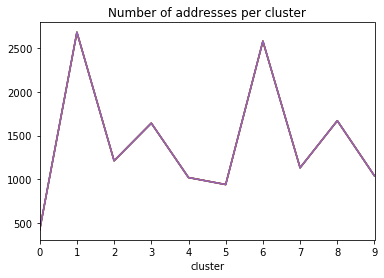

In [25]:
df5.groupby(by=['cluster']).count().plot(legend=False, title='Number of addresses per cluster')

#### Try to visualize the clusters

Do so in terms of the:
- HeatSupply used
- EnergyLabelClassification
- solar potential values: solgruppe1, solgruppe2, solgruppe3

Text(0.5, 1, 'Clusters accorging to the energy source and classification and solar potential')

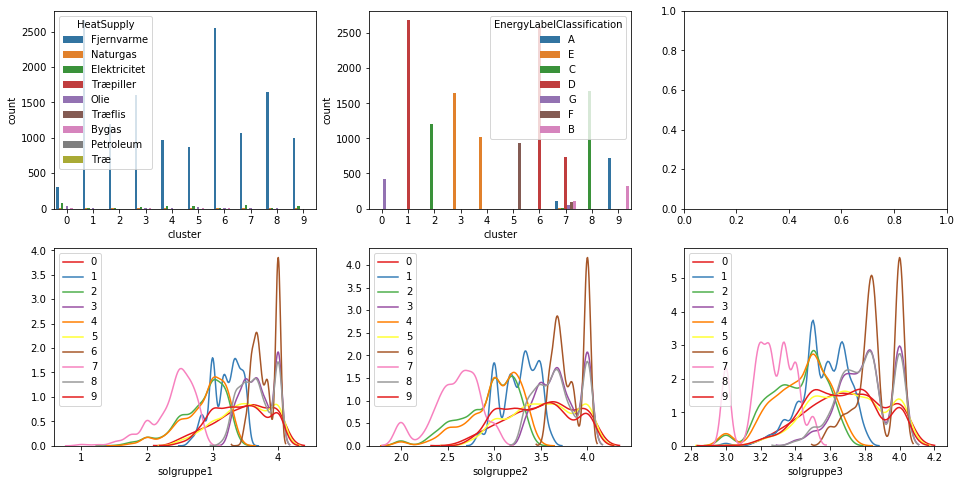

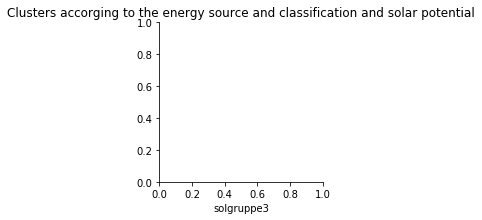

In [26]:
fig, ax = plt.subplots(2, 3, sharey=False, sharex=False, figsize=(16, 8))
sns.countplot(x='cluster', hue='HeatSupply', data=df5, ax=ax[0,0])
sns.countplot(x='cluster', hue='EnergyLabelClassification', data=df5, ax=ax[0,1])
g = sns.FacetGrid(df5, hue="cluster", palette="Set1")
g = (g.map(sns.distplot, 'solgruppe1', hist=False, rug=False, ax=ax[1, 0]))
g = (g.map(sns.distplot, 'solgruppe2', hist=False, rug=False, ax=ax[1, 1]))
g = (g.map(sns.distplot, 'solgruppe3', hist=False, rug=False, ax=ax[1, 2]))

plt.title('Clusters accorging to the energy source and classification and solar potential')

### Conclusions:
- HeatSupply: the majority have District Heating (Fjernvarme) and so this feature contribute little to the clusters' separability
- EnergyLabelClassification: the majority of houses are in the mid-range level (classes C, D and E)
- solar potential: it looks like cluster number 6 (brown) has the best distribution in terms of solar protential. From this very crude analysis, it seems like installing some roof solar pannels on the respective buildings should help offset a bit the energy required for heating. And since the majority of those buildings fall into Energy Level D, it kind of makes even more sense to look into it.

### Add the the cluster information to the main dataframe

In [27]:
final = pd.concat([df, df5['cluster']], axis=1)
final.head()

,address_year,EnergyLabelClassification,HeatSupply,solgruppe1,solgruppe2,solgruppe3,cluster
0,Richard Mortensens Vej_18B_2300_København S_2018,A,Fjernvarme,3.2,3.2,3.6,9
1,Richard Mortensens Vej_18C_2300_København S_2018,A,Fjernvarme,4.0,4.0,4.0,9
2,Metrovej_5_2300_København S_2009,A,Fjernvarme,1.8,2.0,3.0,7
3,Robert Jacobsens Vej_20P_2300_København S_2018,A,Fjernvarme,2.6,2.6,3.2,7
4,Hvidovre Enghavevej_5_2650_Hvidovre_1954,E,Naturgas,4.0,4.0,4.0,3
